## Libraries

In [19]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import date,timedelta

import matplotlib as plt
import pandas as pd

from pandas import DataFrame
from matplotlib import pyplot

import itertools
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator

## Dates used in project

In [20]:
today = date.today() 
print("Today date is: ", today)
tomorrow = today + timedelta(days=1)
tomorrow_string = str(tomorrow)
print("tomorrow date is: ", tomorrow)
print("to string : " , tomorrow_string)
print(type(tomorrow_string))
next_week_begin = today + timedelta(days=7)
print("Next week is :", next_week_begin)
next_week_end = next_week_begin + timedelta(days=7)
print("End next week is :", next_week_end)

Today date is:  2021-01-14
tomorrow date is:  2021-01-15
to string :  2021-01-15
<class 'str'>
Next week is : 2021-01-21
End next week is : 2021-01-28


## Loading of the the dataset

In [21]:
data = pd.read_excel('WindForecast_20210112-20210118.xls' , header = None  ,index_col= False )
data = data.iloc[4:]
data.columns = ['DateTime','Week-ahead Forecast [MW]','Day-ahead forecast [MW]' , 'Most recent forecast [MW]','Measured & upscaled [MW]','Monitored Capacity [MW]','Active Decremental Bids [yes/no]' ,'Day-ahead forecast(11h00) [MW]']
data['DateTime'] = pd.to_datetime(data['DateTime'])

# EDA : Exploratory Data Analysis

In [22]:
data.head()

,DateTime,Week-ahead Forecast [MW],Day-ahead forecast [MW],Most recent forecast [MW],Measured & upscaled [MW],Monitored Capacity [MW],Active Decremental Bids [yes/no],Day-ahead forecast(11h00) [MW]
4,2021-12-01 00:00:00,1466.06,3558.2,3536.08,3390.06,4670.83,No,3508.03
5,2021-12-01 00:15:00,1510.05,3566.38,3544.98,3433.99,4670.83,No,3518.98
6,2021-12-01 00:30:00,1442.41,3572.99,3554,3482.05,4670.83,No,3527.87
7,2021-12-01 00:45:00,1458.09,3578.06,3562.79,3486.22,4670.83,No,3535.23
8,2021-12-01 01:00:00,1493.55,3580.62,3501.62,3498.25,4670.83,No,3540.6


In [23]:
data.describe()

<ipython-input-23-2bb0b18689d4>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe()


,DateTime,Week-ahead Forecast [MW],Day-ahead forecast [MW],Most recent forecast [MW],Measured & upscaled [MW],Monitored Capacity [MW],Active Decremental Bids [yes/no],Day-ahead forecast(11h00) [MW]
count,672,672.00,288.00,672.00,252.00,672.000,672,384.00
unique,672,668.00,288.00,671.00,252.00,1.000,1,384.00
top,2021-01-17 01:15:00,2136.02,625.05,2035.69,1534.96,4670.829,No,3583.96
freq,1,2.00,1.00,2.00,1.00,672.000,672,1.00
first,2021-01-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2021-12-01 23:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# From the information above you see that all the data is normalized between -1.0 and 1.0
# Check the datatypes used in this dataset
data.dtypes.value_counts()

object            7
datetime64[ns]    1
dtype: int64

In [25]:
# Show the last 5 datatypes
data.dtypes.tail()

Most recent forecast [MW]           object
Measured & upscaled [MW]            object
Monitored Capacity [MW]             object
Active Decremental Bids [yes/no]    object
Day-ahead forecast(11h00) [MW]      object
dtype: object

### Changing dataset for DateTime Index

In [26]:
data.to_csv('Windforcast.csv' , index = False)
df = pd.read_csv('Windforcast.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df[df['DateTime'].dt.minute == 0]

In [27]:
df.head()

,DateTime,Week-ahead Forecast [MW],Day-ahead forecast [MW],Most recent forecast [MW],Measured & upscaled [MW],Monitored Capacity [MW],Active Decremental Bids [yes/no],Day-ahead forecast(11h00) [MW]
0,2021-12-01 00:00:00,1466.06,3558.20,3536.08,3390.06,4670.829,No,3508.03
4,2021-12-01 01:00:00,1493.55,3580.62,3501.62,3498.25,4670.829,No,3540.60
8,2021-12-01 02:00:00,1597.20,3586.57,3536.58,3531.04,4670.829,No,3548.69
12,2021-12-01 03:00:00,1684.34,3593.28,3616.85,3578.76,4670.829,No,3562.67
16,2021-12-01 04:00:00,1689.73,3592.74,3649.54,3632.46,4670.829,No,3581.01


# LSTM model 

## Dataset 

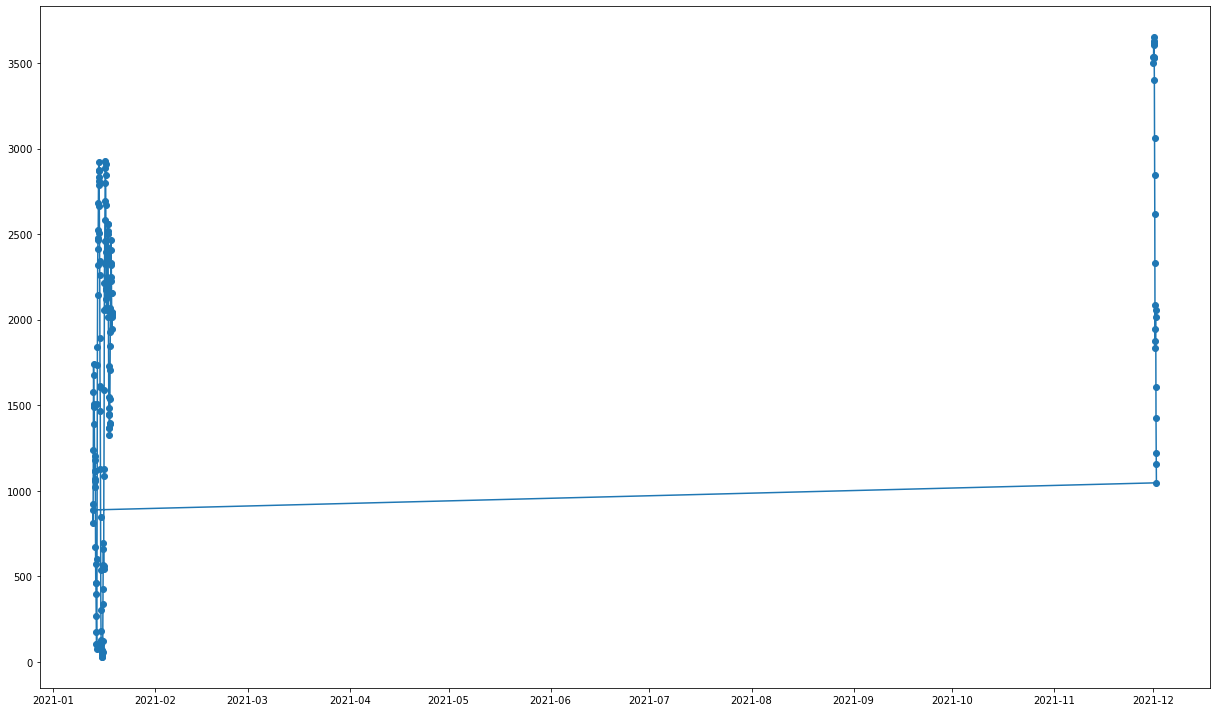

In [28]:
value = df['Most recent forecast [MW]']
dates = plt.dates.date2num(df['DateTime'])
plt.pyplot.figure(figsize=(17,10))
plt.pyplot.plot_date(dates , value ,  linestyle='solid')
plt.pyplot.tight_layout()
plt.pyplot.show()

#plt.pyplot.plot_date(dates, df['Most recent forecast [MW]'])

In [29]:
count_rows = df['Most recent forecast [MW]'].count()
train_length = round((count_rows / 100)*75)
test_length = round((count_rows / 100)*25)

print(count_rows)
print(train_length)
print(test_length)

train = df['Most recent forecast [MW]'].dropna().iloc[0:train_length] 
test = df['Most recent forecast [MW]'].dropna().iloc[train_length:]  

x = df['Most recent forecast [MW]'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1)) 
dataset = scaler.fit_transform(x)


train_data = dataset[0:train_length, : ]

#Splitting the data
x_train=[]
y_train = []

for i in range(10, len(train_data)):
    x_train.append(train_data[i-10:i,0])
    y_train.append(train_data[i,0])
    

168
126
42


In [30]:
#Convert to numpy arrays
x_train=  np.array(x_train)
y_train = np.array(y_train)

#Reshape the data into 3-D array
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [31]:
from keras.layers import Dropout

# Initialising the RNN
model = Sequential()

model.add(LSTM(units = 10, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 1))

# For Full connection layer we use dense
# As the output is 1D so we use unit=1
model.add(Dense(units = 1))

Text(0.5, 0, 'epoch')

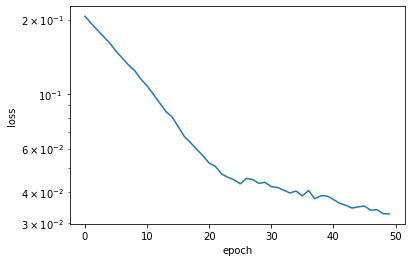

In [32]:
#compile and fit the model on 50 epochs
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(x_train, y_train, epochs = 50, batch_size = 50 , verbose = 0)
plt.pyplot.semilogy(history.history['loss'])
plt.pyplot.ylabel('loss')
plt.pyplot.xlabel('epoch')

In [33]:
#Test data set
test_data = dataset[test_length - 10: , : ]

#splitting the x_test and y_test data sets
x_test = []
y_test =  dataset[test_length : , : ] 

for i in range(10,len(test_data)):
    x_test.append(test_data[i-10:i,0])
    
#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into 3-D array
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [34]:
predictions = model.predict(x_test)
scaled = scaler.inverse_transform(predictions)

In [35]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

MAE: 0.1546890524875754
MSE: 0.031714948371072846
RMSE: 0.17808691240816335


In [36]:
import pickle
pickle.dump(model, open('LSTM.pkl','wb'))

TypeError: cannot pickle 'weakref' object